In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

In [ ]:
# Install requirements after mounting drive, then comment out, restart runtime
%%capture
%cd /content/drive/My Drive/covid_tweets/code
!pip install -r requirements.txt

In [ ]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LogisticRegression, LinearRegression, LogisticRegressionCV, RidgeCV, RANSACRegressor
from hyperopt import fmin, tpe, hp, anneal, Trials, STATUS_OK

from datetime import datetime
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn_pandas import DataFrameMapper
import gc

%matplotlib inline

np.random.seed(12)
random_state= 31
eps = 1E-14
data_path = "/content/drive/My Drive/covid_tweets/data/"

In [ ]:
def geteventDate(EVENT):

  if EVENT=="delhiriots":
    EVENT_DATE = 'Feb 23 2020'

  elif EVENT == "juntaCurfew":
    EVENT_DATE = 'Mar 22 2020'
  elif EVENT =="firstLock":
    EVENT_DATE = 'Mar 24 2020'
  elif EVENT == "tabliqi":
    EVENT_DATE = 'Mar 31 2020'

  elif EVENT=="PalgharMobLynch":
    EVENT_DATE = 'Apr 16 2020'
  elif EVENT == "ramdan":
    EVENT_DATE = "Apr 23 2020"

  elif EVENT=="migrantraildeath":
    EVENT_DATE="May 8 2020"
  elif EVENT =="idulfitr":
    EVENT_DATE='MAY 24 2020'
  elif EVENT == "3agrordinance":
    EVENT_DATE = "Jun 5 2020"

  elif EVENT == "sushantSingh":
    EVENT_DATE = "Jun 14 2020"
  elif EVENT=="ChinaBorderClash":
    EVENT_DATE = "Jun 15 2020"
  elif EVENT == "Coronil":
    EVENT_DATE = "Jun 23 2020"
  elif EVENT == "railSuspension":
    EVENT_DATE = "Jun 25 2020"
  elif EVENT == "pulwama":
    EVENT_DATE="Jul 5 2020"
  elif EVENT == "farmerprotest":
    EVENT_DATE = "Aug 9 2020"
  elif EVENT == "BLRiot":
    EVENT_DATE = "Aug 11 2020"
  elif EVENT=="exam":
    EVENT_DATE = "Aug 23 2020"
  elif EVENT == "gdpcontracts":
    EVENT_DATE = "Aug 31 2020"
  elif EVENT=="IPL":
    EVENT_DATE = "Sep 19 2020"
  elif EVENT=="BiharManifesto":
    EVENT_DATE="Oct 22 2020"
  elif EVENT == "diwali":
    EVENT_DATE = "Nov 14 2020"
  elif EVENT == "lovejihadlaw":
    EVENT_DATE = "Oct 31 2020"
  elif EVENT == "lovejihad":
    EVENT_DATE = "Nov 28 2020"
  EVENT_DATE = datetime.strptime(EVENT_DATE, '%b %d %Y').date()
  return pd.to_datetime(EVENT_DATE).normalize()

EVENTS = ["juntaCurfew"
          , "tabliqi"
          , "migrantraildeath"
          , "Coronil"
          , "exam"
          , "gdpcontracts"
          , "BiharManifesto"
          ]

## utils

In [ ]:
def get_data(EVENT, ntopics, WINDOW):
  df = pd.read_csv(f"{data_path}causal_data_{EVENT}_{str(WINDOW)}_allcovariates_topics-{ntopics}{'_merged' if merge else ''}.csv", index_col=0)
  df['user_created_at']  = (geteventDate(EVENT) - pd.to_datetime(df['user_created_at'], errors='coerce')).dt.days
  df = df.loc[:,cols]

  df['user_followers_count'] = np.arcsinh(df['user_followers_count'])
  df['user_friends_count'] = np.arcsinh(df['user_friends_count'])
  df['tweet_frequency'] = np.arcsinh(df['tweet_frequency'])
  df['retweet_count'] = np.arcsinh(df['retweet_count'])

  df['interact'] = df['interact'].astype(int)

  if 'muslim' in cols:
    df['muslim'] = df['muslim'].astype(int)
  df['user_id'] = df['user_id'].astype(int)
  return df

In [ ]:
def plotfeatures(df):
  plt.figure(figsize=(7, 5))
  for feature in ["retweet_count"]:
    sns.kdeplot(data = df[feature], color = 'darkblue')
    plt.show()

In [ ]:
def scaleFeaturesAndSplit(df):
  mapper = DataFrameMapper([(df.columns.drop(intcols), StandardScaler())])
  scaled_features = mapper.fit_transform(df[df.columns.drop(intcols)].copy(), 4)# 4 is for rounding precision
  scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns.drop(intcols))

  scaled_features_df['interact'] = df['interact']
  if 'muslim' in intcols:
    scaled_features_df['muslim'] = df['muslim']
  scaled_features_df['user_id'] = df['user_id']

  df = scaled_features_df
  del scaled_features_df
  gc.collect()

  kf = StratifiedKFold(n_splits=OUTER_SPLITS, shuffle=True, random_state = 17)
  kfsplits = kf.split(df, df[T])
  splits = list(kfsplits)
  splits = [(split[0], split[1]) for split in splits]
  return df, splits

In [ ]:
def rfRegressorCV(X_train, Y_train):
  param_grid = {'n_estimators': [1000], 'max_depth': [None], 'max_features':[.1, .25, .5, .75,  1],
                'min_samples_split':[2], 'min_samples_leaf':[1]}
  selector = RandomForestRegressor(random_state=0, n_jobs = -1)
  gs = GridSearchCV(selector, param_grid, cv=INNER_SPLITS, refit=False, n_jobs=-1)#, scoring=default is rsq for rf
  gs.fit(X_train, Y_train)
  model = RandomForestRegressor(n_estimators = gs.best_params_['n_estimators'],
                                   max_depth = gs.best_params_['max_depth'],
                                   max_features = gs.best_params_['max_features'],
                                   min_samples_leaf = gs.best_params_['min_samples_leaf'],
                                   random_state=0, n_jobs = -1)
  model.fit(X_train, Y_train)
  return model

def svrCV(X_train, Y_train):
  param_grid = {'C': [.5, .3,.8, 1, 12,56], 'epsilon': [0.2, 0.1,0.3]}
  selector = SVR()
  gs = GridSearchCV(selector, param_grid, cv=INNER_SPLITS, refit=False, n_jobs=-1)#, scoring=default is rsq for rf
  gs.fit(X_train, Y_train)
  model = SVR(C = gs.best_params_['C'], epsilon = gs.best_params_['epsilon'])
  model.fit(X_train, Y_train)
  return model

def regModel(X_train, Y_train, method):
  if method =="ridge":
    alphas = np.logspace(-3, -1, 100)
    model =  RidgeCV(alphas=alphas, cv=INNER_SPLITS).fit(X_train, Y_train)
  if method=="lasso":
    model = LassoCV(n_alphas = 100, cv=INNER_SPLITS, random_state=42,
                    n_jobs= -1, max_iter = 15000).fit(X_train, Y_train)
  if method =="rf":
    model = rfRegressorCV(X_train, Y_train)
  if method=="svr":
    model = svrCV(X_train, Y_train)
  if method=="ransac":
    alphas = np.logspace(-3, -1, 100)
    model = RANSACRegressor(base_estimator = RidgeCV(alphas=alphas, cv=INNER_SPLITS)).fit(X_train, Y_train)
  ypred = model.predict(X_train)
  rsq = r2_score(Y_train, ypred)
  mse = mean_squared_error(Y_train, ypred)
  return model, rsq, mse

Metalearners: code adapted from and figures from https://matheusfacure.github.io/python-causality-handbook/21-Meta-Learners.html

### Slearner

In [ ]:
def slearner(df, splits, Y, method):
  test_mse, train_mse = 0, 0
  test_rsq, train_rsq = 0, 0
  df["Scate"] = 100
  for (train_index, test_index) in splits:
    model, cvrsq, cvmse  = regModel(df.iloc[train_index][X+[T]], df.iloc[train_index][Y], method)
    train_rsq +=cvrsq
    train_mse +=cvmse
    test_rsq += r2_score(df.iloc[test_index][Y], model.predict(df.iloc[test_index][X+[T]]))
    test_mse += mean_squared_error(df.iloc[test_index][Y], model.predict(df.iloc[test_index][X+[T]]))
    df.loc[test_index,"Scate"] = model.predict(df.iloc[test_index][X].assign(**{T: 1})) - model.predict(df.iloc[test_index][X].assign(**{T: 0})) # predict under treatment - predict under control
  assert len(df[df["Scate"]==100])==0, "error Scate not set"
  train_rsq/=OUTER_SPLITS
  train_mse/=OUTER_SPLITS
  test_rsq/=OUTER_SPLITS
  test_mse/=OUTER_SPLITS
  return df, train_rsq, train_mse, test_rsq, test_mse

### T Learner

<div>
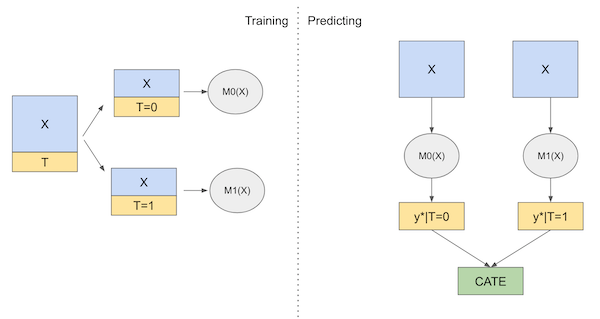

In [ ]:
def tlearner(df, splits, Y, method):
  test_mse0, train_mse0 = 0, 0
  test_rsq0, train_rsq0 = 0, 0
  test_mse1, train_mse1 = 0, 0
  test_rsq1, train_rsq1 = 0, 0
  df["Tcate"] = 100
  df["stage1xcate"] = 100

  for (train_index, test_index) in splits:
    df0_train = df[(df.index.isin(train_index)) &(df[T]==0)]
    df1_train = df[(df.index.isin(train_index)) & (df[T]==1)]
    df0_test = df[(df.index.isin(test_index)) &(df[T]==0)]
    df1_test = df[(df.index.isin(test_index)) &(df[T]==1)]

    m0, cvrsq0, cvmse0 = regModel(df0_train[X], df0_train[Y], method)
    train_rsq0 +=cvrsq0
    train_mse0 +=cvmse0
    ypred0 =  m0.predict(df0_test[X])
    test_rsq0 += r2_score(df0_test[Y], ypred0)
    test_mse0 += mean_squared_error(df0_test[Y], ypred0)

    m1, cvrsq1, cvmse1  = regModel(df1_train[X], df1_train[Y], method)
    train_rsq1 +=cvrsq1
    train_mse1 +=cvmse1
    y1pred = m1.predict(df1_test[X])
    test_rsq1 += r2_score(df1_test[Y], y1pred)
    test_mse1 += mean_squared_error(df1_test[Y], y1pred)

    dftest= df.iloc[test_index]
    df.loc[test_index,"Tcate"] = m1.predict(dftest[X]) - m0.predict(dftest[X])
    df.loc[(df.index.isin(test_index)) & (df[T]==0),"stage1xcate"]= m1.predict(dftest[dftest[T]==0][X]) - dftest[dftest[T]==0][Y]
    df.loc[(df.index.isin(test_index)) & (df[T]==1),"stage1xcate"]= dftest[dftest[T]==1][Y] - m0.predict(dftest[dftest[T]==1][X])

  assert len(df[df["Tcate"]==100])==0,"error Tcate not set"
  assert len(df[df["stage1xcate"]==100])==0,"error stage 1 xcate not set"

  train_rsq0/=OUTER_SPLITS
  train_mse0/=OUTER_SPLITS
  test_rsq0/=OUTER_SPLITS
  test_mse0/=OUTER_SPLITS

  train_rsq1/=OUTER_SPLITS
  train_mse1/=OUTER_SPLITS
  test_rsq1/=OUTER_SPLITS
  test_mse1/=OUTER_SPLITS
  return df, train_rsq0, train_mse0, test_rsq0, test_mse0, train_rsq1, train_mse1, test_rsq1, test_mse1

### X Learner

In [ ]:
def get_classifier(Train, classifier):
  if classifier=="LR":
    clf= LogisticRegressionCV(Cs = 200, cv=10, random_state=random_state)
  else:
    space={'n_estimators': hp.quniform("n_estimators", 30, 2000, 1),
            'max_depth': hp.quniform("max_depth", 3, 20,1),
            'min_samples_leaf': hp.uniform('min_samples_leaf', int(len(Train)/600), int(len(Train)/300))
            }

    trials = Trials()
    def hyperparameter_tuning(space):
      model= RandomForestClassifier(n_estimators = int(space['n_estimators']),
                                      max_depth = int(space['max_depth']),
                                      min_samples_leaf = int(space['min_samples_leaf']),
                                      class_weight= "balanced", random_state=random_state)

      model.fit(Train[X], Train[T] )
      score = cross_val_score(model, Train[X], Train[T],
                              cv=KFold(n_splits=10, random_state=123, shuffle=True).split(Train[X], Train[T]),
                              scoring='neg_log_loss')
      # Extract the best score
      best_loss = score.mean() #minimize mean neg log loss
      return {'loss':best_loss, 'status': STATUS_OK, 'model': model}

    best=fmin(fn=hyperparameter_tuning, # function to optimize
              space=space,
              algo=anneal.suggest, # optimization algorithm, hyperotp will select its parameters automatically
              max_evals=10, # maximum number of iterations
              trials=trials,
              rstate=np.random.default_rng(random_state) # fixing random state for the reproducibility
            )

    # # computing the score on the test set
    clf = RandomForestClassifier(random_state=random_state,
                          n_estimators=int(best['n_estimators']), max_depth=int(best['max_depth']),
                          min_samples_leaf = int(best['min_samples_leaf']),
                          class_weight= "balanced",)
  clf.fit(Train[X], Train[T])
  return clf

In [ ]:
def getPropensityScoreModel(df, splits):
  trainf1, testf1 = 0,0
  df["propensityT"] = 100
  df["propensityNT"] = 100

  for (train_index, test_index) in splits:
    clf = get_classifier(df.iloc[train_index], "LR")
    testf1 += f1_score(df.iloc[test_index][T], clf.predict(df.iloc[test_index][X]))
    trainf1 += f1_score(df.iloc[train_index][T], clf.predict(df.iloc[train_index][X]))
    df.loc[test_index,"propensityT"] = clf.predict_proba(df.iloc[test_index][X])[:,1]
    df.loc[test_index,"propensityNT"] = clf.predict_proba(df.iloc[test_index][X])[:,0]

  assert len(df[df["propensityT"]==100])==0,"error propensity treated not set"
  assert len(df[df["propensityNT"]==100])==0,"error propensity not treated not set"

  return df, trainf1/OUTER_SPLITS, testf1/OUTER_SPLITS

In [ ]:
def xlearner(df, splits, method):
  Y = "stage1xcate"

  test_mse0, train_mse0 = 0, 0
  test_rsq0, train_rsq0 = 0, 0
  test_mse1, train_mse1 = 0, 0
  test_rsq1, train_rsq1 = 0, 0
  df["Xcate"] = 100

  for (train_index, test_index) in splits:
    df0_train = df[(df.index.isin(train_index)) &(df[T]==0)]
    df1_train = df[(df.index.isin(train_index)) &(df[T]==1)]
    df0_test = df[(df.index.isin(test_index)) &(df[T]==0)]
    df1_test = df[(df.index.isin(test_index)) &(df[T]==1)]

    m0, cvrsq0, cvmse0 = regModel(df0_train[X], df0_train[Y], method)
    train_rsq0 +=cvrsq0
    train_mse0 +=cvmse0
    ypred0 =  m0.predict(df0_test[X])
    test_rsq0 += r2_score(df0_test[Y], ypred0)
    test_mse0 += mean_squared_error(df0_test[Y], ypred0)

    m1, cvrsq1, cvmse1  = regModel(df1_train[X], df1_train[Y], method)
    train_rsq1 +=cvrsq1
    train_mse1 +=cvmse1
    y1pred = m1.predict(df1_test[X])
    test_rsq1 += r2_score(df1_test[Y], y1pred)
    test_mse1 += mean_squared_error(df1_test[Y], y1pred)

    dftest = df.iloc[test_index]
    df.loc[test_index,"Xcate"] = dftest["propensityNT"]*m0.predict(dftest[X]) + dftest["propensityT"]*m1.predict(dftest[X])

  assert len(df[df["Xcate"]==100])==0,"error Xcate not set"

  train_rsq0/= OUTER_SPLITS
  train_mse0/=OUTER_SPLITS
  test_rsq0/=OUTER_SPLITS
  test_mse0/=OUTER_SPLITS

  train_rsq1/=OUTER_SPLITS
  train_mse1/=OUTER_SPLITS
  test_rsq1/=OUTER_SPLITS
  test_mse1/=OUTER_SPLITS

  return df, train_rsq0, train_mse0, test_rsq0, test_mse0, train_rsq1, train_mse1, test_rsq1, test_mse1

## Fix Choices

In [ ]:
WINDOW = 7
ntopics = 7
merge = True
reduced = 4

OUTER_SPLITS = 10 # outer level in nested kfold
INNER_SPLITS = 10

Y = "gcs_diff"
Alt_Y = ['valence_intensity_diff',
 'anger_intensity_diff',
 'fear_intensity_diff',
 'sadness_intensity_diff',
 'joy_intensity_diff'] + [f'topic_{i}_diff' for i in range(0, reduced if merge else ntopics)]

T = "interact"

X = ['user_followers_count','user_created_at', 'user_friends_count',
       'retweet_count', 'reply', 'tweet_frequency']

X = X + ['muslim_score']

X = X + ['valence_intensity', 'gcs',
           'anger_intensity', 'fear_intensity',
           'sadness_intensity', 'joy_intensity']+ [f'topic_{i}' for i in range(0, reduced if merge else ntopics)]

cols = [Y, T]
cols.extend(X)
cols.extend(Alt_Y)
cols.append('user_id')

cols.append('muslim') # not a covariate, retaining for heterogeneity analysis

intcols = ['interact'] + ['muslim'] + ['user_id']

print(f"Covariate:{X}")

## Experiments: All events

In [ ]:
def runstxlearners(method):
  results = []
  outpath = f"{data_path}{str(WINDOW)}_{method}_{ntopics}{'_merged' if merge else''}/"
  if not os.path.isdir(outpath):
    os.mkdir(outpath)
  for EVENT in EVENTS:
    print(EVENT)
    df = get_data(EVENT, ntopics, WINDOW)
    df, skfsplits  = scaleFeaturesAndSplit(df)

    #propensity score
    df, train_f1, test_f1 = getPropensityScoreModel(df, skfsplits)

    for y in [Y]+Alt_Y:
      #slearner
      df, train_rsq_s, train_mse_s, test_rsq_s, test_mse_s = slearner(df, skfsplits, y, method = method)

      #tlearner
      df, train_rsq_t0, train_mse_t0, test_rsq_t0, test_mse_t0, train_rsq_t1, train_mse_t1, test_rsq_t1, test_mse_t1 = tlearner(df, skfsplits, y, method = method)

      #xlearner
      df, train_rsq_x0, train_mse_x0, test_rsq_x0, test_mse_x0, train_rsq_x1, train_mse_x1, test_rsq_x1, test_mse_x1 = xlearner(df, skfsplits, method = method)

      #organize evaluation scores
      results.append({"event":EVENT, "Y":y, "train_rsq_s":train_rsq_s, "train_mse_s":train_mse_s, "test_rsq_s":test_rsq_s, "test_mse_s":test_mse_s,
                      "train_rsq_t0":train_rsq_t0, "train_mse_t0":train_mse_t0, "test_rsq_t0":test_rsq_t0, "test_mse_t0":test_mse_t0,
                      "train_rsq_t1":train_rsq_t1, "train_mse_t1":train_mse_t1, "test_rsq_t1": test_rsq_t1, "test_mse_t1":test_mse_t1,
                      "train_rsq_x0":train_rsq_x0, "train_mse_x0":train_mse_x0, "test_rsq_x0":test_rsq_x0, "test_mse_x0":test_mse_x0,
                      "train_rsq_x1":train_rsq_x1, "train_mse_x1":train_mse_x1, "test_rsq_x1": test_rsq_x1, "test_mse_x1":test_mse_x1,
                      "pclf_F1_train":train_f1, "pclf_F1_test":test_f1})
      df[f"Scate_{y}"]= df["Scate"]
      df[f"Tcate_{y}"]= df["Tcate"]
      df[f"Xcate_{y}"]= df["Xcate"]
      del df["Tcate"], df["Xcate"], df["Scate"], df["stage1xcate"]
    del df["propensityT"], df["propensityNT"]

    df.to_csv(outpath+f"stx_learner{EVENT}.csv")
    print(f"done {EVENT}")
  results = pd.DataFrame(results)
  results.to_csv(outpath+f"evaluation_stx_learner.csv")

  test =pd.DataFrame()
  for EVENT in EVENTS:
    df= pd.read_csv(outpath+f"stx_learner{EVENT}.csv", index_col=0)
    df["EVENT"] = EVENT
    test = pd.concat([test, df], axis = 0)
  test.to_csv(outpath + f"test_stxcate_allevents.csv", index=0)
  df_x = test.loc[:, [col for  col in test.columns if (not col.startswith("Tcate")) and (not col.startswith("Scate"))]]
  df_x["learner"] = "Xcate"

  df_t = test.loc[:, [col for  col in test.columns if (not col.startswith("Xcate")) and (not col.startswith("Scate"))]]
  df_t["learner"] = "Tcate"

  df_s = test.loc[:, [col for  col in test.columns if (not col.startswith("Xcate")) and (not col.startswith("Tcate"))]]
  df_s["learner"] = "Scate"

  for y in [Y]+Alt_Y:
    df_x[f"TE_{y}"]=df_x[f"Xcate_{y}"]
    del df_x[f"Xcate_{y}"]
    df_t[f"TE_{y}"]=df_t[f"Tcate_{y}"]
    del df_t[f"Tcate_{y}"]
    df_s[f"TE_{y}"]=df_s[f"Scate_{y}"]
    del df_s[f"Scate_{y}"]

  test = pd.concat([df_x,df_t, df_s], axis=0)
  test.to_csv(outpath + f"stx_long.csv", index=0)

  results = []
  for y in [Y]:#+Alt_Y:
    for EVENT in EVENTS:
      hinduTE={}
      muslimTE = {}
      all_TE= {}
      for learner in ["Tcate", "Xcate", "Scate"]:
        hinduTE[learner] = test[(test["EVENT"]==EVENT)&(test["learner"]==learner)&(test["muslim"]==0)][f"TE_{y}"].mean()
        muslimTE[learner] = test[(test["EVENT"]==EVENT)&(test["learner"]==learner)&(test["muslim"]==1)][f"TE_{y}"].mean()
        all_TE[learner] = test[(test["EVENT"]==EVENT)&(test["learner"]==learner)][f"TE_{y}"].mean()
        test_len  = len(test[(test["EVENT"]==EVENT)&(test["learner"]==learner)])
      results.append({"event":EVENT, "len":test_len,
                      "Sh":hinduTE["Scate"], "Sm":muslimTE["Scate"], "Sa": all_TE["Scate"],
                      "Th":hinduTE["Tcate"], "Tm":muslimTE["Tcate"], "Ta":all_TE["Tcate"],
                      "Xh":hinduTE["Xcate"], "Xm":muslimTE["Xcate"], "Xa":all_TE["Xcate"]})
  results = pd.DataFrame(results).round(3)
  results.to_csv(outpath + f"avgTE_stxcate.csv", index=0)

In [ ]:
runstxlearners(method = "lasso")#"ridge" etc